# Analyzing Neighborhood in Hyderabad, India to start a restaurant

## Introduction

Hyderabad city is the sixth-most populous urban cluster in India. Western parts of the city have rapidly grown in the recent times, owing to IT and Service Sector while the eastern parts have become residential hubs while the central part forms the commercial, economic and cultural core of the city. I was born and broughtup in this city and I have huge bonding to this place. The multi-cultural nature and increase in multinational companies in the city of Hyderabad has brought along with it numerous cuisines from all over the world. The people of India generally love food and I personally love to try different cuisines and experience different flavors. Thus, the aim of this project is to study the neighborhoods in Hyderabad to determine possible locations for opening a restaurant. This project can be useful for business owners and entrepreneurs who are looking to invest in a restaurant in Hyderabad. The main objective of this project is to carefully analyze appropriate data and find recommendations for the stakeholders.


## Data Collection

For this project, we need the followng data:

1. Neighborhood Data: The data of the neighborhoods in Hyderabad was extracted from https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Hyderabad. The data is read into a pandas data frame using the read_html() method. Wikipedia page provides a comprehensive and detailed table of the data which can easily be extracted using the read_html() method of pandas.

2. Geographical coordinates: The geographical coordinates of Hyderabad can be obtained from the GeoPy library in python. This data is relevant for plotting the map of Hyderabad using the Folium library in python. The geocoder library in python can be used to obtain latitude and longitude data for various neighborhoods in Hyderabad and the coordinates of all neighborhoods in Hyderabad are used to check the accuracy of coordinates given on Wikipedia and replace them in our data frame if the absolute difference is more than 0.001. These coordinates are then further used for plotting using the Folium library in python.

3. Venue Data: The venue can be extracted using the Foursquare API. This data contains venue recommendations for all neighborhoods in Hyderabad and is used to study the popular venues of different neighborhoods.

### Importing Required libraries

In [9]:
!pip install geopy
!pip install geocoder
!pip install folium

import numpy as np
import pandas as pd
import json
from geopy.geocoders import Nominatim
import geocoder
import requests
from bs4 import BeautifulSoup
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io.json import json_normalize
from sklearn.metrics import silhouette_score

%matplotlib notebook

print('All libraries imported.')

All libraries imported.


### Neighborhood Data Retreiving
Extracting the data from https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Hyderabad to help us analyze about which location is best to start a restaurant.


In [10]:
# send the GET request
data = requests.get("https://en.wikipedia.org/wiki/Category:Neighbourhoods_in_Hyderabad,_India").text
# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(data, 'html.parser')
# create a list to store neighborhood data
neighborhoodList = []
# append the data into the list
for row in soup.find_all("div", class_="mw-category")[0].findAll("li"):
    neighborhoodList.append(row.text)

In [11]:
# create a new DataFrame from the list
hyd_df = pd.DataFrame({"Neighborhood": neighborhoodList})

hyd_df.head(10)

,Neighborhood
0,A. S. Rao Nagar
1,A.C. Guards
2,Abhyudaya Nagar
3,Abids
4,Adibatla
5,Adikmet
6,Afzal Gunj
7,Aghapura
8,"Aliabad, Hyderabad"
9,Alijah Kotla


In [12]:
# print the number of rows of the dataframe
hyd_df.shape

(200, 1)

In [13]:
# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Hyderabad, India'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [14]:
# call the function to get the coordinates, store in a new list using list comprehension
coordinates = [ get_latlng(neighborhood) for neighborhood in hyd_df["Neighborhood"].tolist() ]

In [15]:
coordinates

[[17.411200000000065, 78.50824000000006],
 [17.393000949133675, 78.45689980427697],
 [17.337650000000053, 78.56414000000007],
 [17.389800000000037, 78.47658000000007],
 [17.235790000000065, 78.54132000000004],
 [17.410610000000077, 78.51513000000006],
 [17.37751000000003, 78.48005000000006],
 [17.38738496982723, 78.46699458034638],
 [17.34259000000003, 78.47626000000008],
 [17.36068000000006, 78.47998000000007],
 [17.503370000000075, 78.41602000000006],
 [17.535430000000076, 78.54427000000004],
 [17.385820000000024, 78.51836000000003],
 [17.53332000000006, 78.32529000000005],
 [17.435350000000028, 78.44861000000003],
 [17.45787000000007, 78.53882000000004],
 [17.40784000000002, 78.49150000000003],
 [17.385140000000035, 78.44738000000007],
 [17.369170000000054, 78.43683000000004],
 [17.40710000000007, 78.50233000000003],
 [17.372720000000072, 78.49047000000007],
 [17.38897000000003, 78.48681000000005],
 [17.39931000000007, 78.49964000000006],
 [17.339920000000063, 78.54553000000004],
 [

In [16]:
# create temporary dataframe to populate the coordinates into Latitude and Longitude
df_coordinates = pd.DataFrame(coordinates, columns=['Latitude', 'Longitude'])

# merge the coordinates into the original dataframe
hyd_df['Latitude'] = df_coordinates['Latitude']
hyd_df['Longitude'] = df_coordinates['Longitude']

# check the neighborhoods and the coordinates
print(hyd_df.shape)
hyd_df.head(10)

(200, 3)


,Neighborhood,Latitude,Longitude
0,A. S. Rao Nagar,17.411200,78.508240
1,A.C. Guards,17.393001,78.456900
2,Abhyudaya Nagar,17.337650,78.564140
3,Abids,17.389800,78.476580
4,Adibatla,17.235790,78.541320
5,Adikmet,17.410610,78.515130
6,Afzal Gunj,17.377510,78.480050
7,Aghapura,17.387385,78.466995
8,"Aliabad, Hyderabad",17.342590,78.476260
9,Alijah Kotla,17.360680,78.479980


In [17]:
# get the coordinates of Hyderabad
address = 'Hyderabad, India'

geolocator = Nominatim(user_agent="My_Project")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Hyderabad, India {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Hyderabad, India 17.38878595, 78.46106473453146.


In [18]:
# create map of Hyderabad using latitude and longitude values
map_hyd = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(hyd_df['Latitude'], hyd_df['Longitude'], hyd_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_hyd)  
    
map_hyd

### Use Foursquare API to explore the Neighborhoods of Hyderabad, India

In [19]:
CLIENT_ID = 'BJSVARMMGIKUWVNHOVIQQFXUJLGSESEQFQYE41DWMP5M2TJC' # your Foursquare ID
CLIENT_SECRET = 'A3JBXFYTFD1L4UNRQSWW2D543SMSFOSAGWIDTIHTUROLRS5I' # your Foursquare Secret
VERSION = '20180604'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: BJSVARMMGIKUWVNHOVIQQFXUJLGSESEQFQYE41DWMP5M2TJC
CLIENT_SECRET:A3JBXFYTFD1L4UNRQSWW2D543SMSFOSAGWIDTIHTUROLRS5I


In [23]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [24]:
hyd_venues = getNearbyVenues(names=hyd_df['Neighborhood'], latitudes=hyd_df['Latitude'], longitudes=hyd_df['Longitude'])
print(hyd_venues.shape)
hyd_venues.head(10)

A. S. Rao Nagar
A.C. Guards
Abhyudaya Nagar
Abids
Adibatla
Adikmet
Afzal Gunj
Aghapura
Aliabad, Hyderabad
Alijah Kotla
Allwyn Colony
Alwal
Amberpet
Ameenpur
Ameerpet
Anandbagh
Ashok Nagar, Hyderabad
Asif Nagar
Attapur
Azamabad, Hyderabad
Azampura
Badichowdi
Bagh Lingampally
Bairamalguda
Balapur, Ranga Reddy district
Balkampet
Banjara Hills
Bank Street, Hyderabad
Barkas, Hyderabad
Barkatpura
Basheerbagh
Bazarghat
Begum Bazaar
Begumpet
Bharat Nagar
BHEL Township, Hyderabad
Boggulkunta
Bolarum
Borabanda
Bowenpally
Chaderghat
Champapet
Chanchalguda
Chandrayan Gutta
Chatta Bazaar
Chengicherla
Cherlapally
Chikkadpally
Chilkalguda
Chintal Basti
Chintalakunta
Dabirpura
Dar-ul-Shifa
Dhoolpet
Dilsukhnagar
Domalguda
Dundigal
ECIL X Roads
Edi Bazar
Erragadda
Fateh Nagar, Hyderabad
Ferozguda
Film Nagar
Gachibowli
Gaddiannaram
Gautham Nagar
Golnaka
Goshamahal
Gudimalkapur
Gulzar Houz
Gundlapochampalli
Habsiguda
Hafeezpet
Hasmathpet
Hastinapuram
Hayathnagar
Himayatnagar, Hyderabad
HITEC City
Hydergud

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,A. S. Rao Nagar,17.411200,78.50824,Baskin-Robbins,17.404311,78.510034,Ice Cream Shop
1,A. S. Rao Nagar,17.411200,78.50824,Srinivasa Textiles,17.407338,78.509908,Clothing Store
2,A. S. Rao Nagar,17.411200,78.50824,Health and glow,17.407333,78.509905,Cosmetics Shop
3,A. S. Rao Nagar,17.411200,78.50824,turnhalle gym,17.407347,78.509941,Gym
4,A. S. Rao Nagar,17.411200,78.50824,Kwality Walls Express,17.407347,78.509956,Ice Cream Shop
5,A. S. Rao Nagar,17.411200,78.50824,Shade Restaurant,17.405024,78.512270,Asian Restaurant
6,A. S. Rao Nagar,17.411200,78.50824,Talwalkars Hifi,17.405122,78.515155,Gym / Fitness Center
7,A.C. Guards,17.393001,78.45690,Cafe Niloufer & Bakers,17.399715,78.462881,Café
8,A.C. Guards,17.393001,78.45690,Subhan Bakery,17.392412,78.464712,Bakery
9,A.C. Guards,17.393001,78.45690,Milan Juice Center,17.392266,78.458102,Snack Place


In [25]:
hyd_venues.groupby('Neighborhood', as_index=False).count()


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,A. S. Rao Nagar,7,7,7,7,7,7
1,A.C. Guards,7,7,7,7,7,7
2,Abhyudaya Nagar,9,9,9,9,9,9
3,Abids,32,32,32,32,32,32
4,Adikmet,15,15,15,15,15,15
...,...,...,...,...,...,...,...
186,Serilingampally,7,7,7,7,7,7
187,Shah-Ali-Banda,12,12,12,12,12,12
188,Shahran Market,15,15,15,15,15,15
189,Shanker Mutt,36,36,36,36,36,36


In [26]:
print('There are {} uniques categories.'.format(len(hyd_venues['Venue Category'].unique())))

There are 187 uniques categories.


In [27]:
# one hot encoding
hyd_onehot = pd.get_dummies(hyd_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
hyd_onehot['Neighborhood'] = hyd_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [hyd_onehot.columns[-1]] + list(hyd_onehot.columns[:-1])
hyd_onehot = hyd_onehot[fixed_columns]

print(hyd_onehot.shape)
hyd_onehot.head(30)

(2836, 187)


,Zoo,ATM,Accessories Store,Afghan Restaurant,Airport Service,American Restaurant,Antique Shop,Arcade,Arts & Crafts Store,Asian Restaurant,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Volleyball Court,Water Park,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
hyd_grouped = hyd_onehot.groupby(["Neighborhood"]).sum().reset_index()
#df.group/by("state")["last_name"].count()

#hyd_onehot.head()
print(hyd_grouped.shape)
hyd_grouped

(191, 187)


,Neighborhood,Zoo,ATM,Accessories Store,Afghan Restaurant,Airport Service,American Restaurant,Antique Shop,Arcade,Arts & Crafts Store,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Volleyball Court,Water Park,Wings Joint,Women's Store,Yoga Studio
0,A. S. Rao Nagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A.C. Guards,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Abhyudaya Nagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Abids,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Adikmet,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,Serilingampally,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
187,Shah-Ali-Banda,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
188,Shahran Market,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
189,Shanker Mutt,0,0,0,0,0,0,0,2,0,...,0,0,0,1,0,0,0,0,0,0


In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = hyd_grouped['Neighborhood']

for ind in np.arange(hyd_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hyd_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,A. S. Rao Nagar,Ice Cream Shop,Cosmetics Shop,Clothing Store,Gym / Fitness Center,Gym,Asian Restaurant,Yoga Studio,Dive Bar,Farmers Market,Farm
1,A.C. Guards,Café,Bakery,Indian Restaurant,Soccer Field,Snack Place,Dance Studio,Deli / Bodega,Fast Food Restaurant,Farmers Market,Farm
2,Abhyudaya Nagar,Indian Restaurant,Hotel,Pharmacy,Burger Joint,Movie Theater,Restaurant,Fast Food Restaurant,Coffee Shop,Deli / Bodega,Donut Shop
3,Abids,Hotel,Indian Restaurant,Bakery,Fast Food Restaurant,Juice Bar,Bed & Breakfast,Department Store,Farmers Market,Breakfast Spot,Shoe Store
4,Adikmet,Ice Cream Shop,Coffee Shop,Cosmetics Shop,Lounge,Sandwich Place,Clothing Store,Asian Restaurant,Café,Indian Restaurant,Platform
...,...,...,...,...,...,...,...,...,...,...,...
186,Serilingampally,Pizza Place,Train Station,Stadium,Ice Cream Shop,Café,Fast Food Restaurant,Dive Bar,Farmers Market,Farm,Falafel Restaurant
187,Shah-Ali-Banda,Hotel,South Indian Restaurant,Indian Restaurant,Juice Bar,Farmers Market,Monument / Landmark,Dessert Shop,Coffee Shop,Clothing Store,Cheese Shop
188,Shahran Market,History Museum,Indian Restaurant,Café,Juice Bar,Monument / Landmark,Diner,Dessert Shop,Cheese Shop,Food Court,Clothing Store
189,Shanker Mutt,Hotel,Bakery,Flea Market,Fast Food Restaurant,Bowling Alley,Snack Place,Pizza Place,Indian Restaurant,Arcade,Juice Bar


### Clustering neighborhoods

Now we can use KMeans clustering method to cluster the neighborhoods of Hyderabad, India.

Silhouette Score is used to determine how many clusters are needed to use.

A function is defined to plot the Silhouette Score that will be calculated using different number of clusters.

In [30]:
def plot(x, y):
    fig = plt.figure(figsize=(12,6))
    plt.plot(x, y, 'o-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Scores')
    plt.title('Checking Optimum Number of Clusters')
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

In [31]:
maxk = 15
scores = []
kval = []

for k in range(2, maxk+1):
    cl_df = hyd_grouped.drop('Neighborhood', axis=1)
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=60).fit_predict(cl_df) #Choose any random_state
    
    score = silhouette_score(cl_df, kmeans, metric='euclidean', random_state=0)
    kval.append(k)
    scores.append(score)

[0.4253665750148555, 0.337204364480235, 0.26202727892354855, 0.2689528944323504, 0.24719731234254325, 0.16596362794322703, 0.1941879607530178, 0.0866732109862991, 0.1776219410888179, 0.19717866761315325, 0.17230530279952522, 0.16124928323877055, 0.17141376559391722, 0.167023104286895]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


<IPython.core.display.Javascript object>


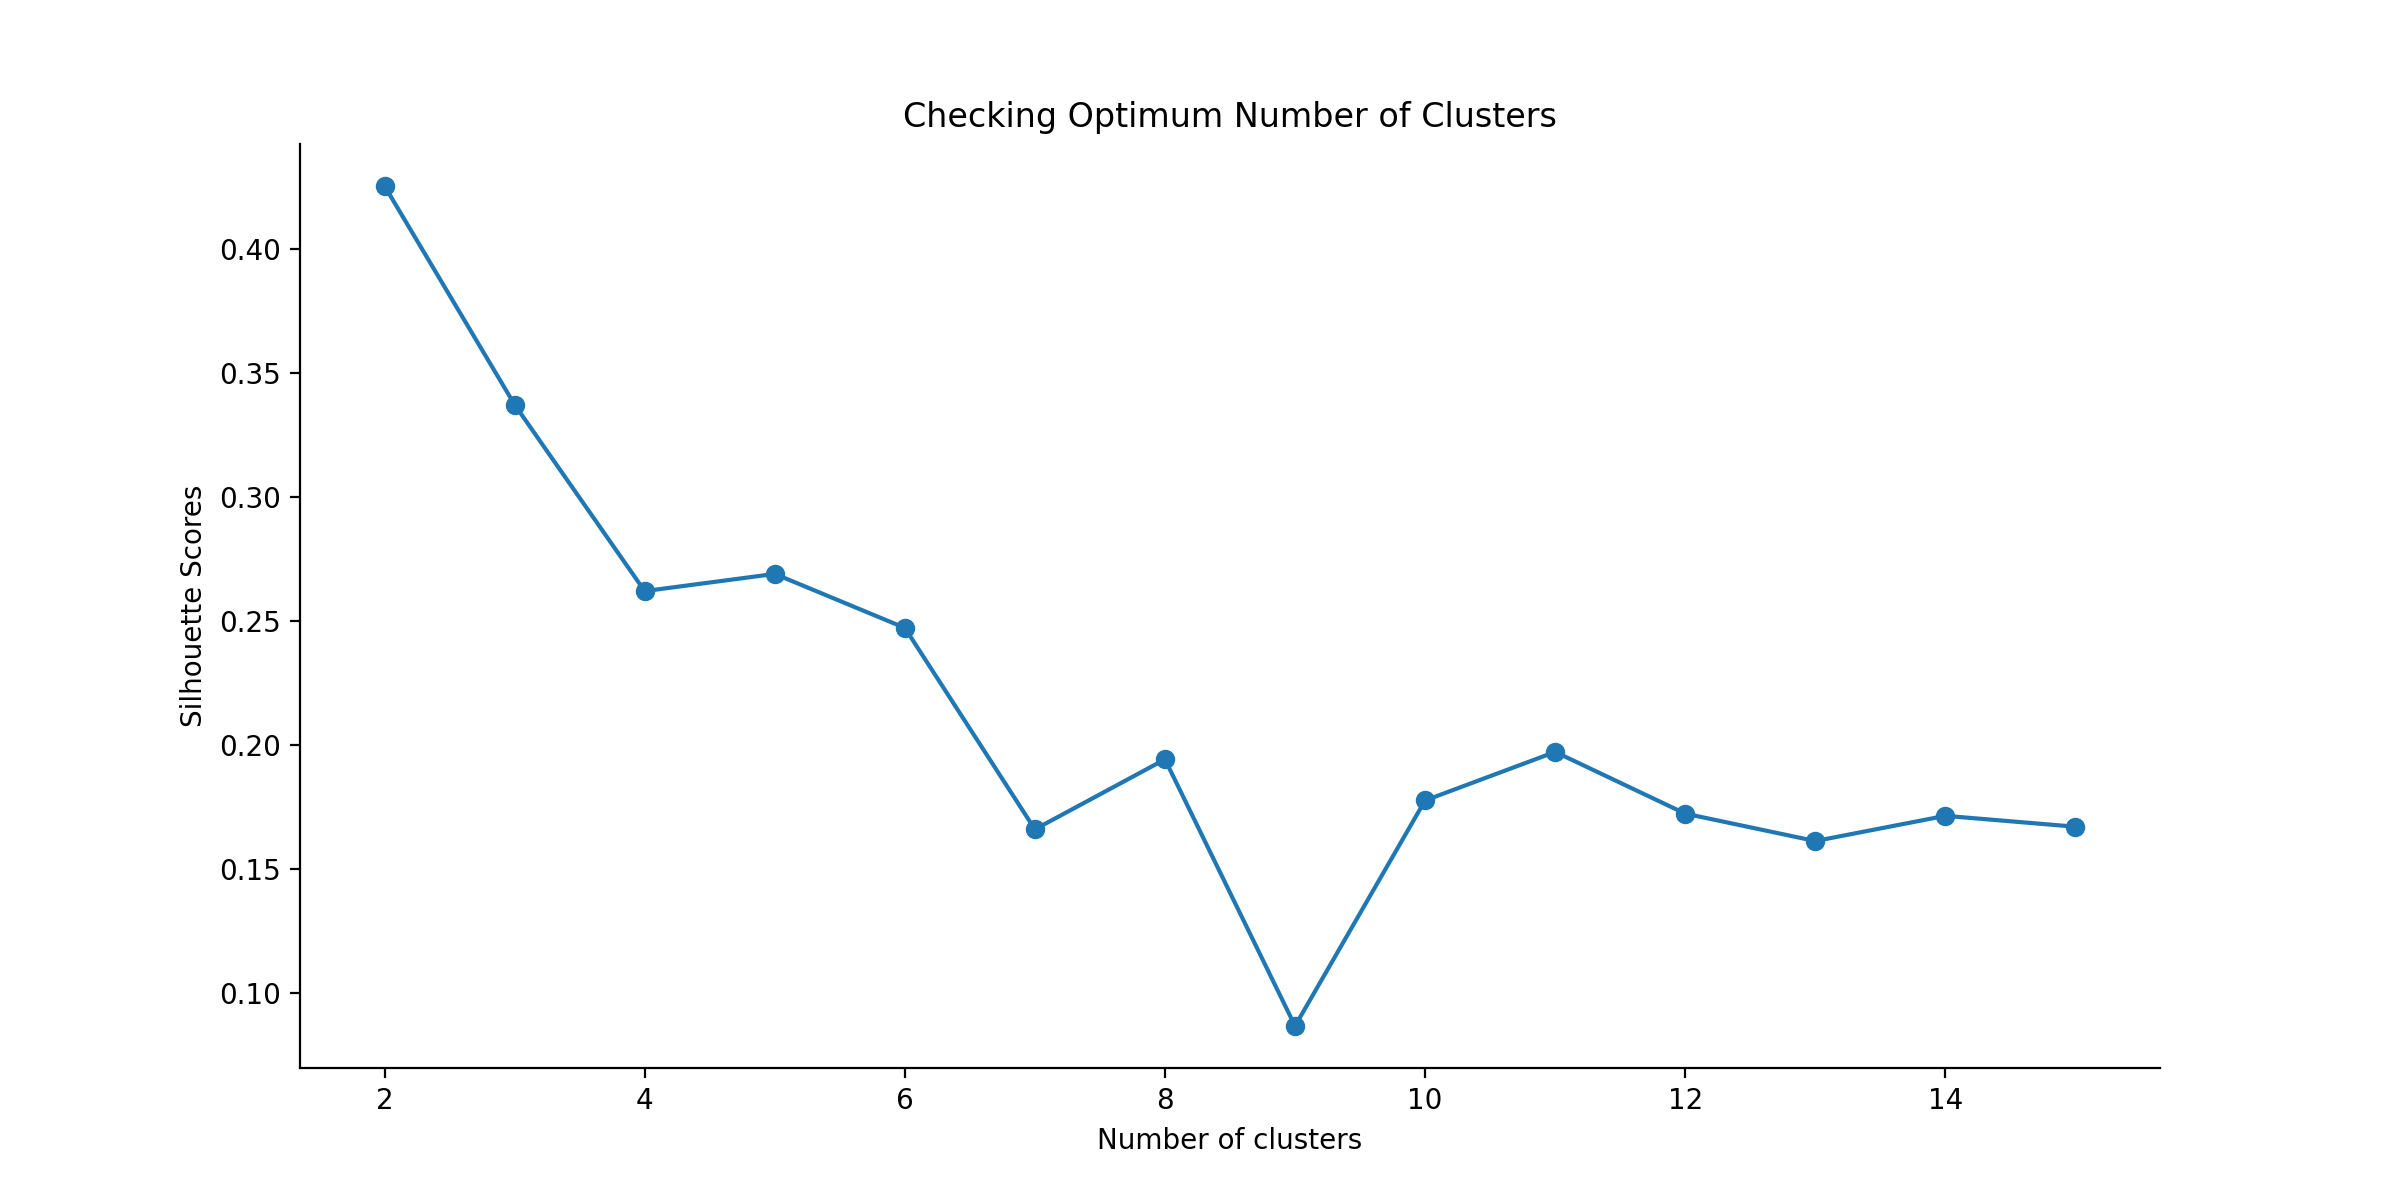

In [32]:
print(scores)
print(kval)
plot(kval, scores)

We can see that the silhouette scores are not very high even as we increase the number of clusters. This means that the inter-cluster distance between different clusters is not very high over the range of k-values. However, we will try to cluster our data as best as we can. For this, we will use 2 clusters for our clustering model since it provides the highest silhouette score as seen above.

In [33]:
k = 2

hyd_clustering = hyd_grouped.drop('Neighborhood', axis=1)
kmeans = KMeans(n_clusters=k, init="k-means++", random_state=80).fit(hyd_clustering) #Can choose any random_state

kmeans.labels_

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1], dtype=int32)

A new dataframe is created that includes cluster labels and the top 10 venues.

In [34]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
hyd_merged = hyd_df
hyd_merged = hyd_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

In [35]:
print(hyd_merged.shape)
hyd_merged

(200, 14)


,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,A. S. Rao Nagar,17.411200,78.50824,1.0,Ice Cream Shop,Cosmetics Shop,Clothing Store,Gym / Fitness Center,Gym,Asian Restaurant,Yoga Studio,Dive Bar,Farmers Market,Farm
1,A.C. Guards,17.393001,78.45690,1.0,Café,Bakery,Indian Restaurant,Soccer Field,Snack Place,Dance Studio,Deli / Bodega,Fast Food Restaurant,Farmers Market,Farm
2,Abhyudaya Nagar,17.337650,78.56414,1.0,Indian Restaurant,Hotel,Pharmacy,Burger Joint,Movie Theater,Restaurant,Fast Food Restaurant,Coffee Shop,Deli / Bodega,Donut Shop
3,Abids,17.389800,78.47658,0.0,Hotel,Indian Restaurant,Bakery,Fast Food Restaurant,Juice Bar,Bed & Breakfast,Department Store,Farmers Market,Breakfast Spot,Shoe Store
4,Adibatla,17.235790,78.54132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,Serilingampally,17.482160,78.32300,1.0,Pizza Place,Train Station,Stadium,Ice Cream Shop,Café,Fast Food Restaurant,Dive Bar,Farmers Market,Farm,Falafel Restaurant
196,Shah-Ali-Banda,17.357390,78.47320,1.0,Hotel,South Indian Restaurant,Indian Restaurant,Juice Bar,Farmers Market,Monument / Landmark,Dessert Shop,Coffee Shop,Clothing Store,Cheese Shop
197,Shahran Market,17.364490,78.47529,1.0,History Museum,Indian Restaurant,Café,Juice Bar,Monument / Landmark,Diner,Dessert Shop,Cheese Shop,Food Court,Clothing Store
198,Shanker Mutt,17.433300,78.49037,0.0,Hotel,Bakery,Flea Market,Fast Food Restaurant,Bowling Alley,Snack Place,Pizza Place,Indian Restaurant,Arcade,Juice Bar


In [36]:
hyd_merged1=hyd_merged.dropna(how='any')

In [37]:
hyd_merged1

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,A. S. Rao Nagar,17.411200,78.50824,1.0,Ice Cream Shop,Cosmetics Shop,Clothing Store,Gym / Fitness Center,Gym,Asian Restaurant,Yoga Studio,Dive Bar,Farmers Market,Farm
1,A.C. Guards,17.393001,78.45690,1.0,Café,Bakery,Indian Restaurant,Soccer Field,Snack Place,Dance Studio,Deli / Bodega,Fast Food Restaurant,Farmers Market,Farm
2,Abhyudaya Nagar,17.337650,78.56414,1.0,Indian Restaurant,Hotel,Pharmacy,Burger Joint,Movie Theater,Restaurant,Fast Food Restaurant,Coffee Shop,Deli / Bodega,Donut Shop
3,Abids,17.389800,78.47658,0.0,Hotel,Indian Restaurant,Bakery,Fast Food Restaurant,Juice Bar,Bed & Breakfast,Department Store,Farmers Market,Breakfast Spot,Shoe Store
5,Adikmet,17.410610,78.51513,1.0,Ice Cream Shop,Coffee Shop,Cosmetics Shop,Lounge,Sandwich Place,Clothing Store,Asian Restaurant,Café,Indian Restaurant,Platform
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,Serilingampally,17.482160,78.32300,1.0,Pizza Place,Train Station,Stadium,Ice Cream Shop,Café,Fast Food Restaurant,Dive Bar,Farmers Market,Farm,Falafel Restaurant
196,Shah-Ali-Banda,17.357390,78.47320,1.0,Hotel,South Indian Restaurant,Indian Restaurant,Juice Bar,Farmers Market,Monument / Landmark,Dessert Shop,Coffee Shop,Clothing Store,Cheese Shop
197,Shahran Market,17.364490,78.47529,1.0,History Museum,Indian Restaurant,Café,Juice Bar,Monument / Landmark,Diner,Dessert Shop,Cheese Shop,Food Court,Clothing Store
198,Shanker Mutt,17.433300,78.49037,0.0,Hotel,Bakery,Flea Market,Fast Food Restaurant,Bowling Alley,Snack Place,Pizza Place,Indian Restaurant,Arcade,Juice Bar


In [38]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i+x+(i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hyd_merged1['Latitude'], hyd_merged1['Longitude'], hyd_merged1['Neighborhood'], hyd_merged1['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


### Cluster1


In [39]:
hyd_merged.loc[hyd_merged['Cluster Labels'] == 0, hyd_merged.columns[[0] + [1] + list(range(2, hyd_merged.shape[1]))]]


,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Abids,17.389800,78.476580,0.0,Hotel,Indian Restaurant,Bakery,Fast Food Restaurant,Juice Bar,Bed & Breakfast,Department Store,Farmers Market,Breakfast Spot,Shoe Store
14,Ameerpet,17.435350,78.448610,0.0,Indian Restaurant,Vegetarian / Vegan Restaurant,Café,Hotel,Chinese Restaurant,Bakery,Gym,Department Store,Deli / Bodega,Clothing Store
16,"Ashok Nagar, Hyderabad",17.407840,78.491500,0.0,Indian Restaurant,Movie Theater,Ice Cream Shop,Café,Dessert Shop,Fast Food Restaurant,Snack Place,Stadium,Sandwich Place,Bakery
27,"Bank Street, Hyderabad",17.388601,78.476645,0.0,Hotel,Indian Restaurant,Bakery,Fast Food Restaurant,Juice Bar,Department Store,Bridal Shop,Breakfast Spot,Shoe Store,Shopping Mall
30,Basheerbagh,17.402110,78.477700,0.0,Indian Restaurant,Fast Food Restaurant,Chinese Restaurant,Café,Restaurant,Hotel,Sandwich Place,Ice Cream Shop,Dessert Shop,Park
31,Bazarghat,17.398105,78.462720,0.0,Hotel,Indian Restaurant,Café,Hyderabadi Restaurant,Bakery,Bank,Ice Cream Shop,Garden,Lounge,Middle Eastern Restaurant
36,Boggulkunta,17.391370,78.480230,0.0,Hotel,Indian Restaurant,Shoe Store,Juice Bar,Fast Food Restaurant,Bakery,Department Store,Shopping Mall,Breakfast Spot,Bridal Shop
49,Chintal Basti,17.406620,78.456590,0.0,Indian Restaurant,Hotel,Pizza Place,Ice Cream Shop,Bakery,Hyderabadi Restaurant,Playground,Park,Department Store,Breakfast Spot
63,Gachibowli,17.431810,78.386360,0.0,Indian Restaurant,Shopping Mall,Fast Food Restaurant,Cafeteria,Café,Clothing Store,Laser Tag,Lounge,Bowling Alley,Brewery
71,Habsiguda,17.417120,78.543500,0.0,Indian Restaurant,Bakery,Restaurant,Bank,Park,Metro Station,Gym,Vegetarian / Vegan Restaurant,Café,Sandwich Place


### Cluster2

In [40]:
hyd_merged.loc[hyd_merged['Cluster Labels'] == 1, hyd_merged.columns[[0] + [1] + list(range(2, hyd_merged.shape[1]))]]


,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,A. S. Rao Nagar,17.411200,78.50824,1.0,Ice Cream Shop,Cosmetics Shop,Clothing Store,Gym / Fitness Center,Gym,Asian Restaurant,Yoga Studio,Dive Bar,Farmers Market,Farm
1,A.C. Guards,17.393001,78.45690,1.0,Café,Bakery,Indian Restaurant,Soccer Field,Snack Place,Dance Studio,Deli / Bodega,Fast Food Restaurant,Farmers Market,Farm
2,Abhyudaya Nagar,17.337650,78.56414,1.0,Indian Restaurant,Hotel,Pharmacy,Burger Joint,Movie Theater,Restaurant,Fast Food Restaurant,Coffee Shop,Deli / Bodega,Donut Shop
5,Adikmet,17.410610,78.51513,1.0,Ice Cream Shop,Coffee Shop,Cosmetics Shop,Lounge,Sandwich Place,Clothing Store,Asian Restaurant,Café,Indian Restaurant,Platform
6,Afzal Gunj,17.377510,78.48005,1.0,Hotel,Bus Station,Farmers Market,History Museum,Food,Chaat Place,Food Truck,Flea Market,Dessert Shop,Ice Cream Shop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,Saroornagar,17.354420,78.53921,1.0,Shopping Mall,Lake,Indian Restaurant,Coffee Shop,Café,Stadium,Indie Movie Theater,Movie Theater,Hyderabadi Restaurant,Electronics Store
195,Serilingampally,17.482160,78.32300,1.0,Pizza Place,Train Station,Stadium,Ice Cream Shop,Café,Fast Food Restaurant,Dive Bar,Farmers Market,Farm,Falafel Restaurant
196,Shah-Ali-Banda,17.357390,78.47320,1.0,Hotel,South Indian Restaurant,Indian Restaurant,Juice Bar,Farmers Market,Monument / Landmark,Dessert Shop,Coffee Shop,Clothing Store,Cheese Shop
197,Shahran Market,17.364490,78.47529,1.0,History Museum,Indian Restaurant,Café,Juice Bar,Monument / Landmark,Diner,Dessert Shop,Cheese Shop,Food Court,Clothing Store


### Results and Discussion Section

By analyzing the two clusters obtained we can see that some of the clusters are more suited for restaurants and hotels, whereas, other clusters are less suited. These clusters contain a higher degree of other venues like hotels, pizza place and clothing store. Thus, they are not well suited for opening a new restaurant. Thus, the neighborhoods in these clusters would be well suited for opening a new restaurant.

Comparing clusters 1 and 2, neighborhoods in cluster 1 seem to be more suited for starting a restaurant since they contains a larger percentage of food joints in the top 10 most common venues than cluster 2. The neighborhoods in cluster 1 contain a variety of food joints like restaurants, tea rooms, bakery, cafe and also contain very diverse cuisines like  Indian, Chinese and seafood restaurants. Most neighborhoods in cluster 2 seem to have Indian Restaurant as their top most common venue; however, on careful analysis we can see that neighborhoods in cluster 2 also contain other venues like Dessert Shop,Pizza place and so on. Thus, it is recommended that the new restaurant can be opened in the neighborhoods belonging to cluster 1.

In [42]:
new_restaurant_neighborhoods = hyd_merged1.loc[hyd_merged1['Cluster Labels'] == 0, hyd_merged1.columns[[0, 1, 2, 3] + list(range(2, hyd_merged1.shape[1]))]]
new_restaurant_neighborhoods.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Abids,17.389800,78.476580,0.0,78.476580,0.0,Hotel,Indian Restaurant,Bakery,Fast Food Restaurant,Juice Bar,Bed & Breakfast,Department Store,Farmers Market,Breakfast Spot,Shoe Store
14,Ameerpet,17.435350,78.448610,0.0,78.448610,0.0,Indian Restaurant,Vegetarian / Vegan Restaurant,Café,Hotel,Chinese Restaurant,Bakery,Gym,Department Store,Deli / Bodega,Clothing Store
16,"Ashok Nagar, Hyderabad",17.407840,78.491500,0.0,78.491500,0.0,Indian Restaurant,Movie Theater,Ice Cream Shop,Café,Dessert Shop,Fast Food Restaurant,Snack Place,Stadium,Sandwich Place,Bakery
27,"Bank Street, Hyderabad",17.388601,78.476645,0.0,78.476645,0.0,Hotel,Indian Restaurant,Bakery,Fast Food Restaurant,Juice Bar,Department Store,Bridal Shop,Breakfast Spot,Shoe Store,Shopping Mall
30,Basheerbagh,17.402110,78.477700,0.0,78.477700,0.0,Indian Restaurant,Fast Food Restaurant,Chinese Restaurant,Café,Restaurant,Hotel,Sandwich Place,Ice Cream Shop,Dessert Shop,Park


### Final observation
We have successfully analyzed the neighborhoods in Hyderabad, India for determining which would be the best neighborhoods for opening a new restaurant. Based on our analysis, neighborhoods in cluster 1 are recommended as locations for the new restaurant. The stakeholders and investors can further tune this by considering various other factors like transport, legal requirements, and costs associated. These were out of the scope for this project and thus were not considered.